In [1]:
from __future__ import print_function

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import struct
import numpy as np
%matplotlib inline

def calcPSNR(ref, img):
    shape = img.shape
    imgVec = img.reshape((shape[0] * shape[1] * shape[2]))
    refVec = ref.reshape((shape[0] * shape[1] * shape[2]))
    mse = np.mean(np.square(np.subtract(refVec, imgVec)))
    return (20 * np.log10(np.max(refVec)) - 10 * np.log10(mse), mse)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
from keras.preprocessing.image import ImageDataGenerator

from model import seg,unet,DMCNN,HDRDMCNN
import numpy as np
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,TerminateOnNaN
from scipy import misc
from keras.callbacks import TensorBoard
import math
import cv2 as cv
import tools.img2raw as im

import tensorflow as tf

models = []

Using TensorFlow backend.


In [2]:
model = DMCNN.dmcnn(128,128,3)
model.load_weights("weight/DMCNN-0.001-27000-128-2019-11-20-03-40-44.h5")
models.append(model)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     31232     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 3)       4803      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 3)       12        
Total params: 44,303
Trainable params: 44,303
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = HDRDMCNN.HDRdmcnn_nonHDR(128,128,3)
model.load_weights("weight/HDRDMCNN-0.0005-27000-128-2019-11-20-21-28-58.h5")
models.append(model)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     31232     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 3)       4803      
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None,

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128, 128, 3)  44291       input_2[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128, 128, 3)  1941151     input_2[0][0]                    
__________________________________________________________________________________________________
add_1 (Add)                     (None, 128, 128, 3)  0           model_2[1][0]                    
                                                                 model_3[1][0]              

In [4]:
model = HDRDMCNN.HDRdmcnn(128,128,3)
model.load_weights("weight/HDRDMCNN-HDR-Data-0.0003-27000-128-2019-12-01-13-59-11.h5")
models.append(model)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 128, 128, 16) 2320        dropout_10[0][0]                 
____________________________________________________________________________________________

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 128, 128, 3)  44303       input_5[0][0]                    
__________________________________________________________________________________________________
model_6 (Model)                 (None, 128, 128, 3)  1941151     input_5[0][0]                    
__________________________________________________________________________________________________
add_2 (Add)                     (None, 128, 128, 3)  0           model_5[1][0]                    
                                                                 model_6[1][0]              

In [5]:
model = unet.unet(128,128,3)
model.load_weights("weight/UNET-0.0002-27000-128-2019-11-20-09-40-42.h5")
models.append(model)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 128, 128, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 128, 128, 16) 2320        dropout_19[0][0]                 
____________________________________________________________________________________________

In [6]:
models_name = ["DMCNN", "HDRDMCNN", "HDRDMCNN-HDR-DATA", "UNET"]

def evaluateModel(models, filename, raw, ref):
    result = []
    f, axarr = plt.subplots(2, len(models) + 1, sharex=True)
    for model in models:
        result.append(model.predict(np.array([raw]))[0])
    # Draw reference
    maxi = np.max(ref)
    axarr[0,0].imshow(ref / maxi, interpolation='nearest')
    axarr[0,0].set_axis_off()
    axarr[0,0].set_title('Reference')
    axarr[1,0].set_axis_off()
    if (maxi > 1.0):
        # axarr[1,0].set_title('Clipped Highlight')
        refR = raw[:,:,0]
        refG = raw[:,:,1]
        refB = raw[:,:,2]
        maskedR = np.greater(refR, 1.0).astype(float)
        maskedG = np.greater(refG, 1.0).astype(float)
        maskedB = np.greater(refB, 1.0).astype(float)
        masked = np.copy(ref)
        masked[:,:,0] = maskedR
        masked[:,:,1] = maskedG
        masked[:,:,2] = maskedB
        # axarr[1,0].imshow(masked)
    f.set_figheight(12)
    f.set_figwidth(6 * (len(models) + 1))
    # Draw models
    for i in range(0, len(models)):
        axarr[0,i+1].imshow(result[i] / maxi, interpolation='nearest')
        imdiff = np.abs(np.subtract(ref, result[i]))
        lum_img = (imdiff[:,:,0] + imdiff[:,:,1] + imdiff[:,:,2])
        axarr[1,i+1].imshow(lum_img, interpolation='nearest', cmap='hot', vmax=maxi, vmin=0)
        axarr[0,i+1].set_axis_off()
        axarr[1,i+1].set_axis_off()
        snr = calcPSNR(ref, result[i])
        axarr[0,i+1].set_title(models_name[i])
        axarr[1,i+1].set_title("pSNR=" + str(snr[0]))
    plt.savefig(filename + ".svg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


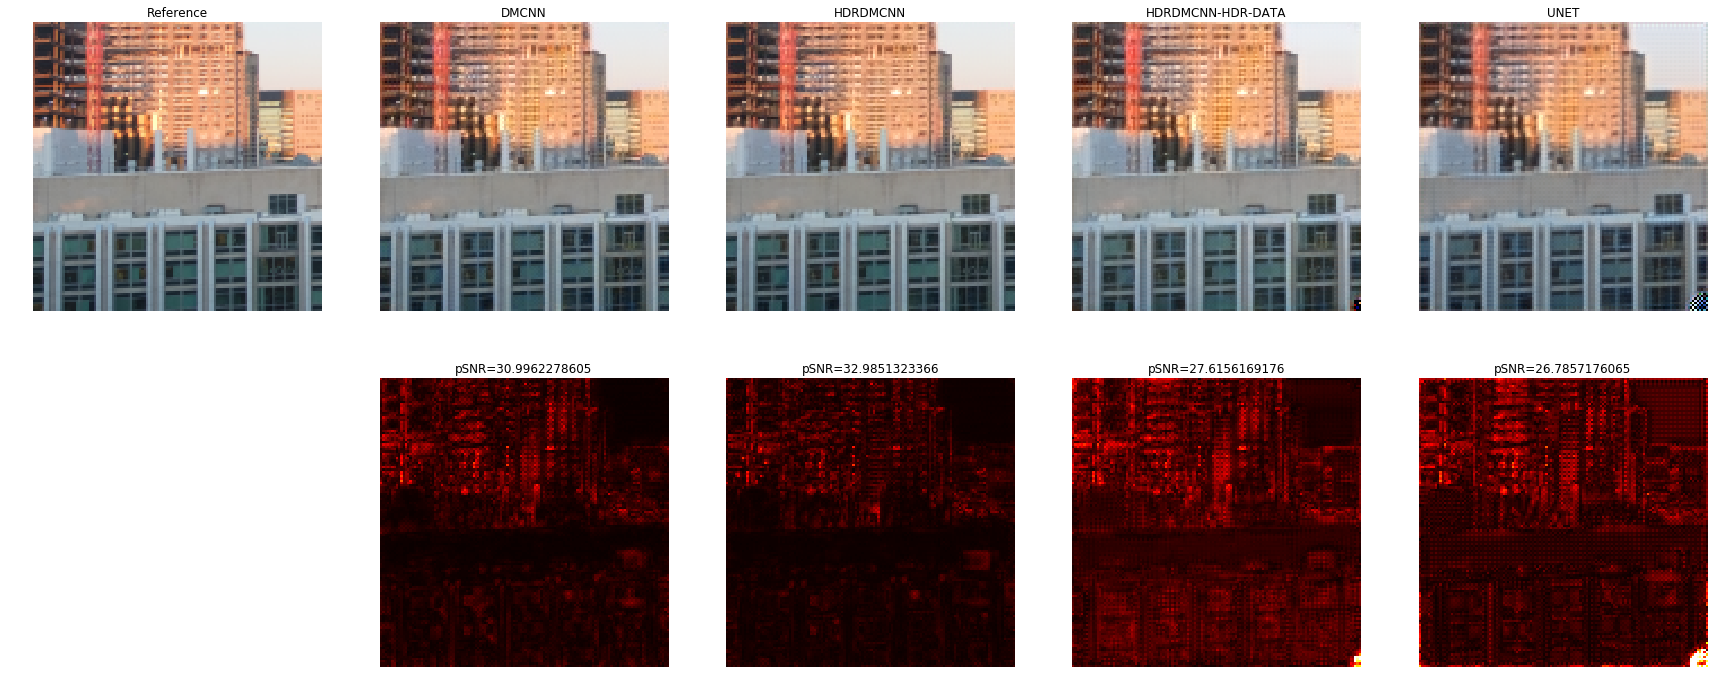

In [7]:
evaluateModel(models, "19440", im.readBinImg("19440.bin"), im.readBinImg("19440ref.bin"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


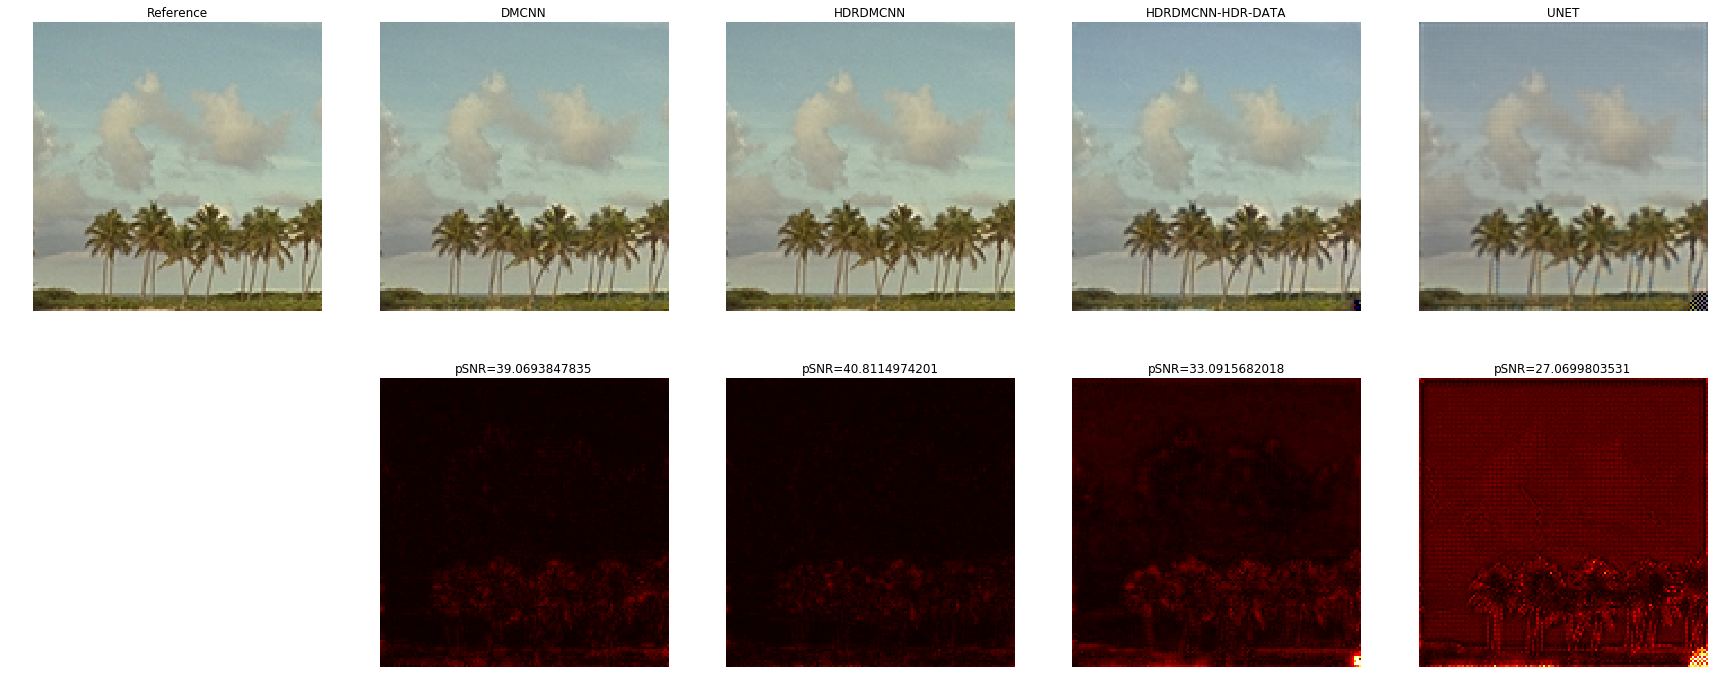

In [8]:
evaluateModel(models, "1528", im.readBinImg("1528.bin"), im.readBinImg("1528ref.bin"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


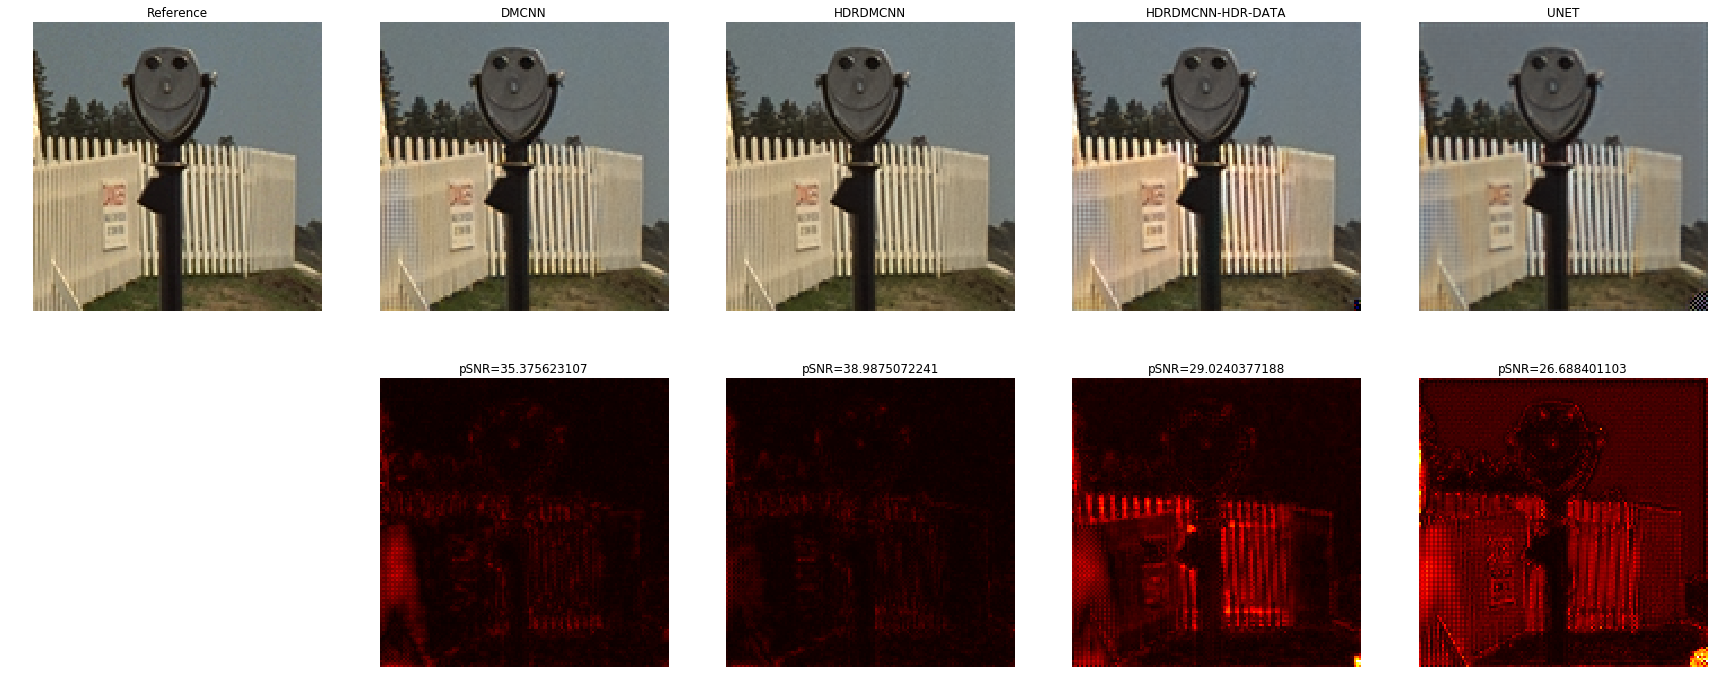

In [9]:
evaluateModel(models, "1756", im.readBinImg("1756.bin"), im.readBinImg("1756ref.bin"))

In [10]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def grey(x):
    return x * 0.5 + 0.5
    
def visualizeFilter(model, layer_id):
    weights = model.layers[layer_id].get_weights()[0]

    print(weights.shape)
    
    xlen = 16
    if weights.shape[3] <= 16:
        xlen = 4
    ylen = int(weights.shape[3] / xlen)

    f, axarr = plt.subplots(ylen, xlen, sharex=True)
    f.subplots_adjust(hspace=0)
    # f.subplots_adjust(vspace=0)
    f.set_figheight(ylen)
    f.set_figwidth(xlen)

    for i in range(ylen):
        for j in range(xlen):
            axarr[i,j].imshow(sigmoid(weights[:,:,:,i * xlen + j]), interpolation='nearest')
            axarr[i,j].set_axis_off()

    plt.show()
    
def visualizeActivation(activations, layer_id):
    weights = activations[layer_id][0]

    print(weights.shape)
    
    xlen = 16
    if weights.shape[2] <= 16:
        xlen = 4
    ylen = int(weights.shape[2] / xlen)

    f, axarr = plt.subplots(ylen, xlen, sharex=True)
    f.subplots_adjust(hspace=0)
    # f.subplots_adjust(vspace=0)
    f.set_figheight(ylen * 5)
    f.set_figwidth(xlen * 5)

    for i in range(ylen):
        for j in range(xlen):
            axarr[i,j].imshow(weights[:,:,i * xlen + j], cmap='gray')
            axarr[i,j].set_axis_off()

    plt.savefig("Layer" + str(layer_id) + ".svg")

(9, 9, 3, 128)


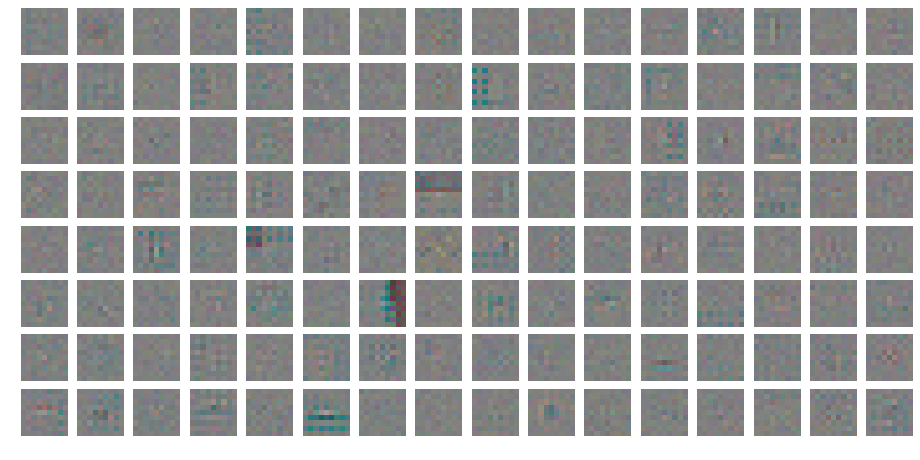

In [11]:
visualizeFilter(models[0], 1)

5
(128, 128, 128)


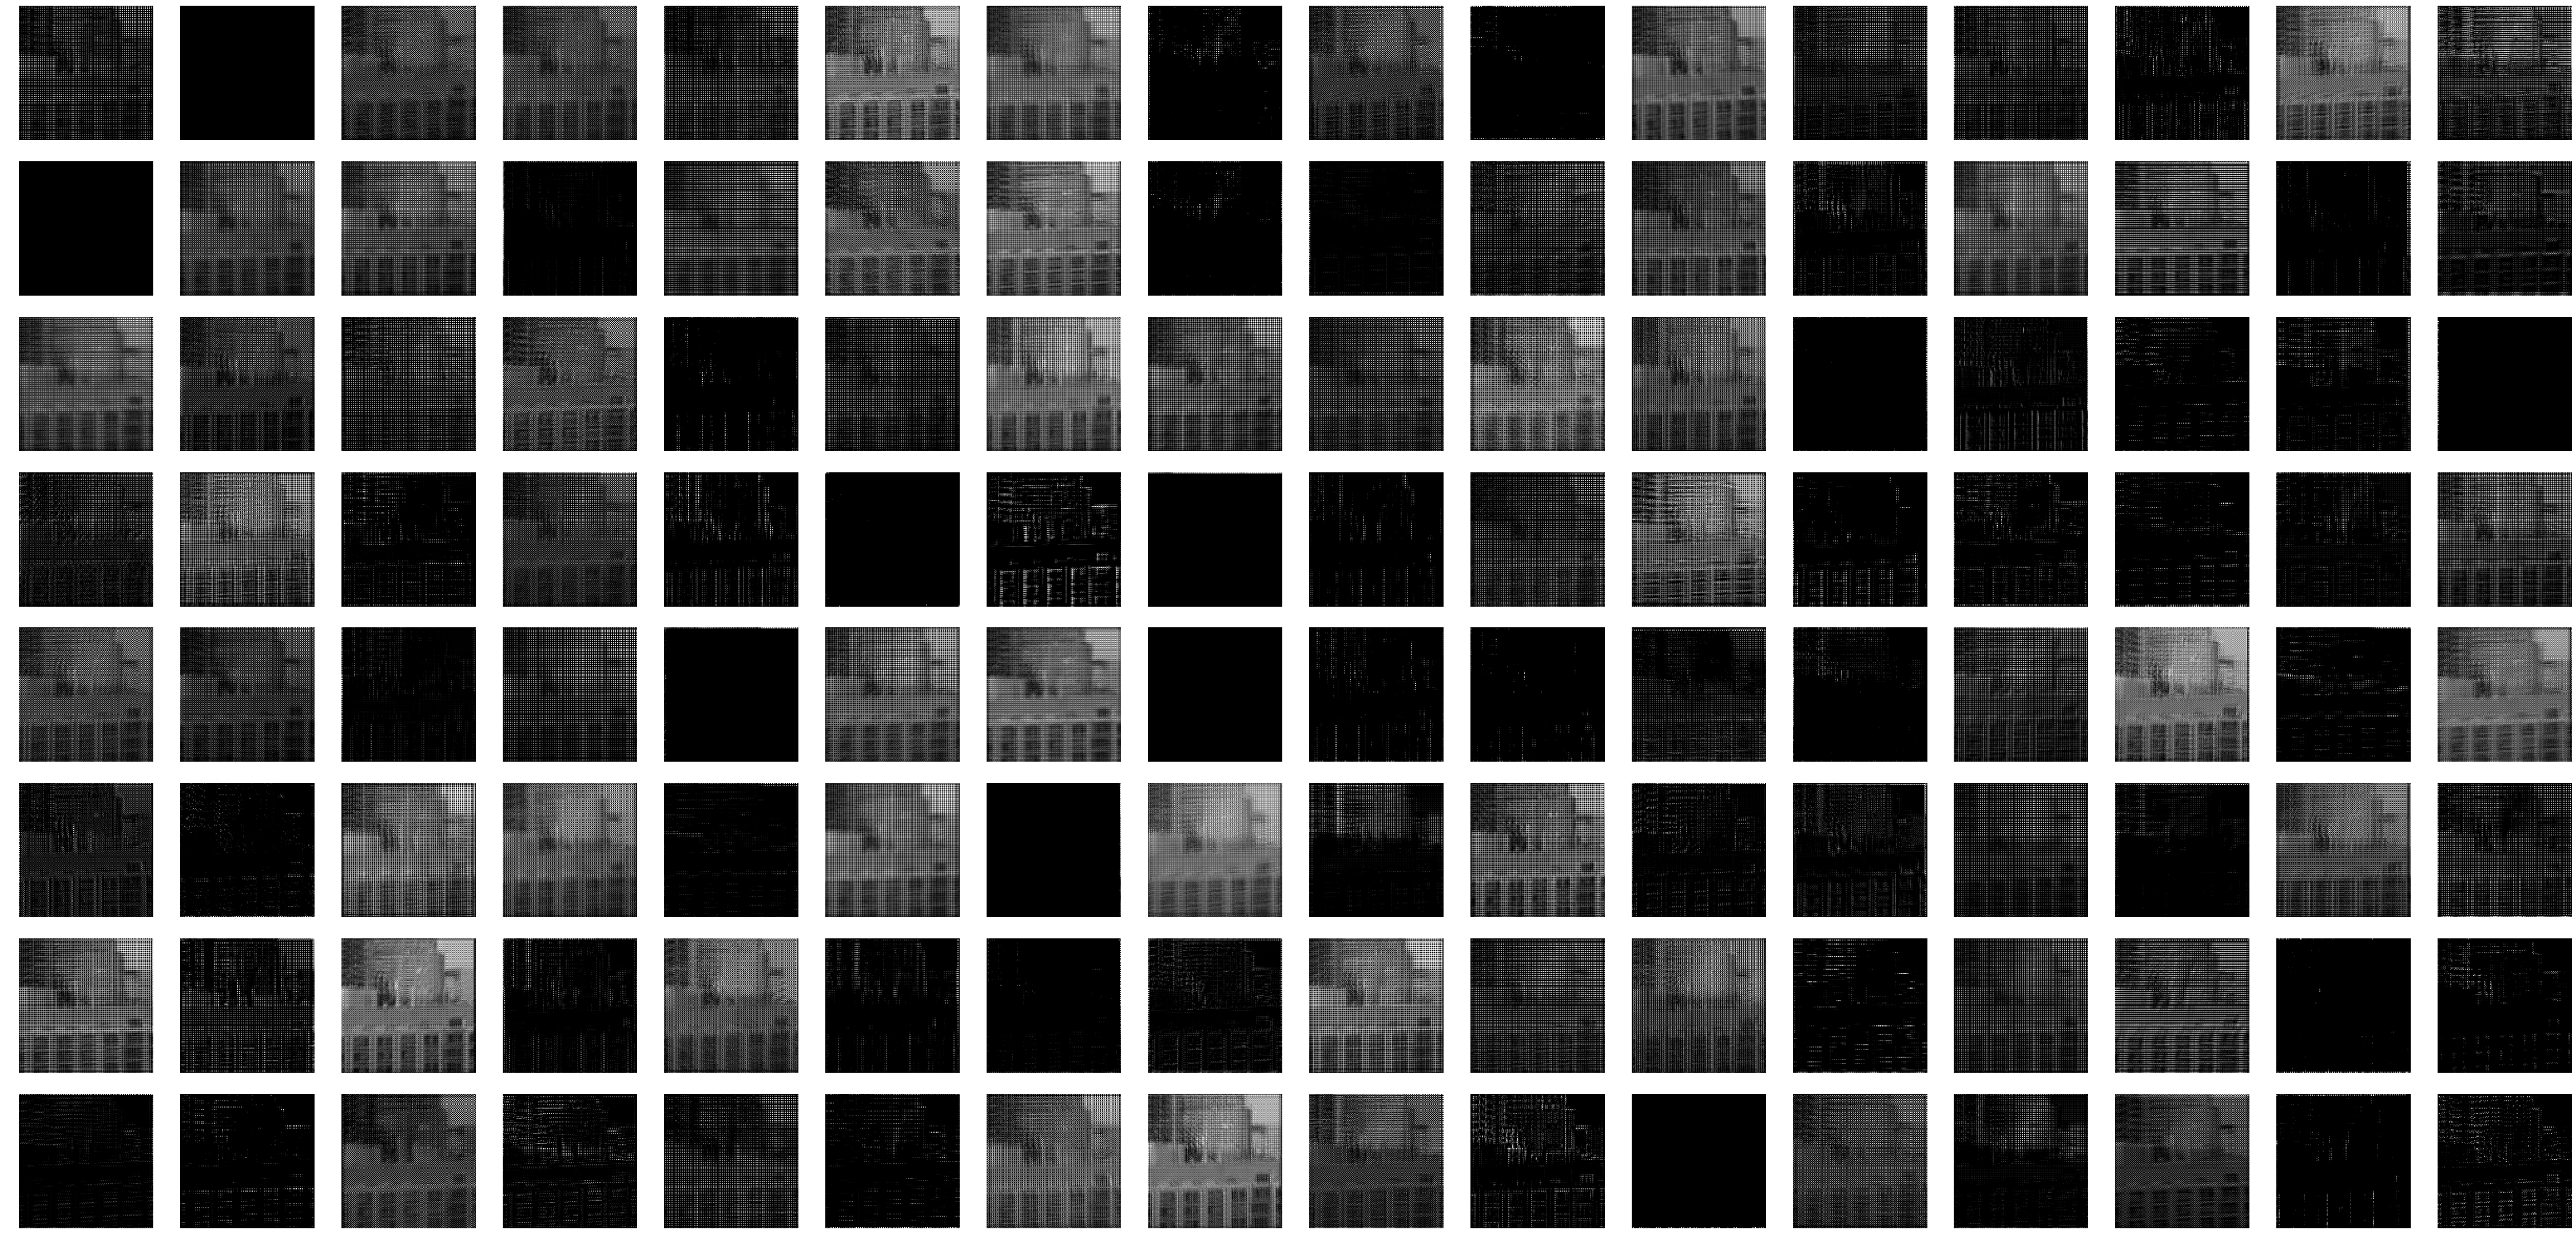

In [12]:
import keras.backend as K
from keras.models import Model

test = im.readBinImg("19440.bin")
ref = im.readBinImg("19440ref.bin")

layer_outputs = [layer.output for layer in models[0].layers]
activation_model = Model(inputs=models[0].input, outputs=layer_outputs)
activations = activation_model.predict(np.array([test]))

print(len(activations))

visualizeActivation(activations, 1)

Text(0.5, 1.0, 'B-(R+G)')

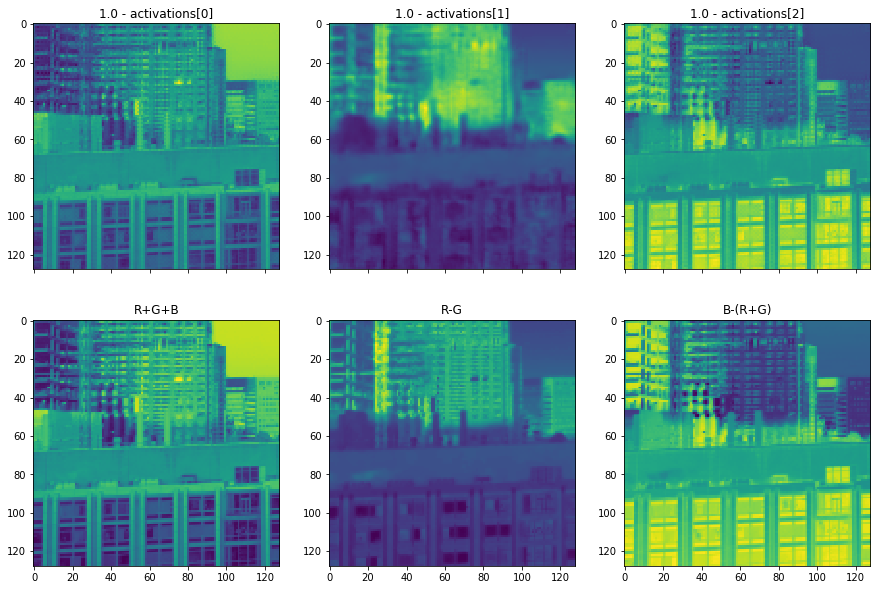

In [13]:
f, ax = plt.subplots(2, 3, sharex=True)
f.set_figheight(10)
f.set_figwidth(15)

ax[0,0].set_title("1.0 - activations[0]")
ax[0,0].imshow(1.0 - activations[3][0][:,:,0])
ax[1,0].imshow(ref[:,:,2] + ref[:,:,1] + ref[:,:,0])
ax[1,0].set_title("R+G+B")

ax[0,1].set_title("1.0 - activations[1]")
ax[0,1].imshow(1.0 - activations[3][0][:,:,1])
ax[1,1].imshow(ref[:,:,0] - ref[:,:,1])
ax[1,1].set_title("R-G")

ax[0,2].set_title("1.0 - activations[2]")
ax[0,2].imshow(1.0 - activations[3][0][:,:,2])
ax[1,2].imshow(ref[:,:,2]-(ref[:,:,1] + ref[:,:,0]))
ax[1,2].set_title("B-(R+G)")

(9, 9, 3, 128)


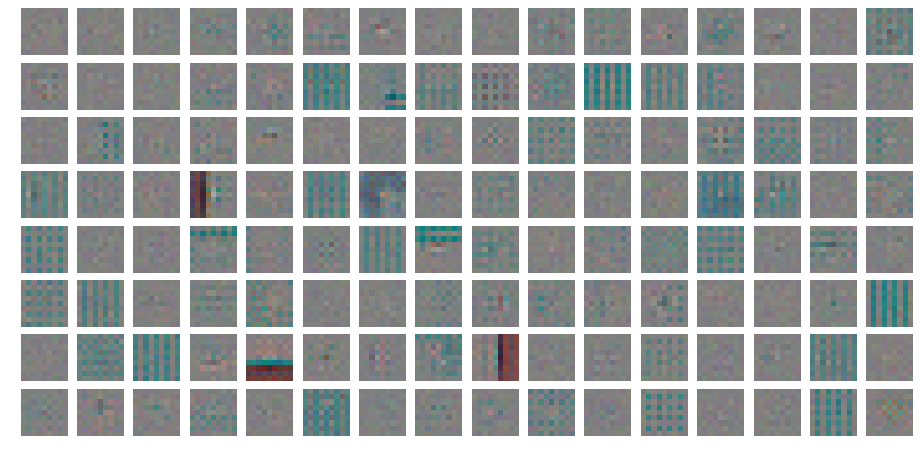

In [14]:
visualizeFilter(models[1], 1)

(9, 9, 3, 128)


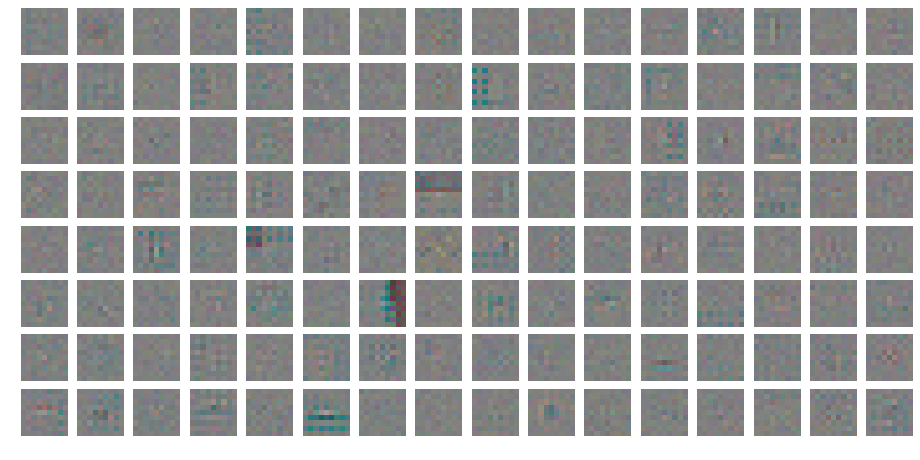

In [15]:
visualizeFilter(models[2], 1)

In [16]:
from os import walk

def evaluateModel(models, directory):
    raws = []
    refs = []
    rawdir = os.path.join(directory, "raw")
    refdir = os.path.join(directory, "ref")
    for filename in os.listdir(rawdir):
        if filename.endswith(".bin"):
            rawpath = os.path.join(rawdir, filename)
            refpath = os.path.join(refdir, filename)
            raws.append(im.readBinImg(rawpath))
            refs.append(im.readBinImg(refpath))
    for model in models:
        results = model.predict(np.array(raws))
        psnrs = []
        for i in range(0, len(results)):
            psnrs.append(calcPSNR(refs[0], results[0])[0])
        print(np.mean(psnrs))

evaluateModel(models, "D:\\NNPhotos\\Kodak\\Data\\SONY NEX-5N.FullRange")

37.5880370289
40.4373011738
32.4442944676
28.4341535717
